# Predicting NHL Game Outcomes

## Modeling Notebook

In [175]:
# Standard Packages
import pandas as pd
# from pandas.testing import assert_frame_equal
import numpy as np
import requests
import re
import time
import os
import warnings

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Modeling Packages
## Modeling Prep
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, \
GridSearchCV, RandomizedSearchCV

## SKLearn Data Prep Modules
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, \
PolynomialFeatures, PowerTransformer, Normalizer, MaxAbsScaler

from sklearn.impute import SimpleImputer

## SKLearn Classification Models
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import svm

## SKLearn Pipeline Setup
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## SKLearn Model Optimization
from sklearn.feature_selection import RFE, f_regression, RFECV

## SKLearn Metrics
### Classification Scoring/Evaluation
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, \
ConfusionMatrixDisplay, log_loss, confusion_matrix, RocCurveDisplay, make_scorer, roc_auc_score

## TensorFlow
#for the Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from keras.constraints import maxnorm

In [107]:
# Notebook Config
from pprintpp import pprint as pp
%reload_ext pprintpp
from io import StringIO

## Suppress Python Warnings (Future, Deprecation)
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Suppress Pandas Warnings (SettingWithCopy)
pd.options.mode.chained_assignment = None

## Pandas Display Config
pd.options.display.max_columns = 80
# pd.options.display.width = None

## Display SKLearn estimators as diagrams
from sklearn import set_config
set_config(display= 'diagram')

0it [00:00, ?it/s]

##  Load Processed CSV

In [108]:
# load modeling df
modeling_df = pd.read_csv('modeling_final.csv', index_col=False)
modeling_df

,season_id,date,Home_team,Away_team,Home_Team_Won,home_rolling_avg_FF%,home_rolling_avg_GF%,home_rolling_avg_xGF%,home_rolling_avg_HDCF%,home_rolling_avg_HDSH%,home_rolling_avg_HDSV%,home_rolling_avg_SH%,home_rolling_avg_SV%,home_rolling_avg_GF/60_pp,home_rolling_avg_xGF/60_pp,home_rolling_avg_GA/60_pk,home_rolling_avg_xGA/60_pk,away_rolling_avg_FF%,away_rolling_avg_GF%,away_rolling_avg_xGF%,away_rolling_avg_HDCF%,away_rolling_avg_HDSH%,away_rolling_avg_HDSV%,away_rolling_avg_SH%,away_rolling_avg_SV%,away_rolling_avg_GF/60_pp,away_rolling_avg_xGF/60_pp,away_rolling_avg_GA/60_pk,away_rolling_avg_xGA/60_pk
0,20192020,2019-10-22,CGY,WSH,0,51.530,49.292,52.171,48.052,6.476,85.008,70.570606,916.011515,6.027,4.839,2.492,6.428,54.229,49.310,55.439,52.822,13.942,77.652,97.903437,916.051875,55.926,17.439,5.719,4.657
1,20192020,2019-10-24,DAL,ANA,1,47.510,44.729,52.979,56.640,23.892,81.519,74.160645,938.801613,5.211,6.131,5.980,4.955,49.075,59.341,50.647,56.223,19.764,92.559,80.736774,912.332581,1.173,4.920,6.614,4.886
2,20192020,2019-10-24,EDM,WSH,1,48.525,41.521,47.858,44.778,18.509,82.631,77.374545,911.065152,13.210,8.734,4.144,7.600,53.307,51.114,54.277,53.132,16.438,75.486,97.903437,916.051875,54.906,17.127,4.801,4.281
3,20192020,2019-10-25,TOR,S.J,1,50.669,49.713,46.325,43.564,26.335,77.804,83.725313,919.072188,9.900,6.012,6.126,5.894,47.301,40.113,42.496,41.539,16.089,81.599,82.280000,875.965937,13.254,9.169,3.008,6.854
4,20192020,2019-10-25,DET,BUF,0,48.081,35.525,49.142,50.718,19.480,75.680,57.837188,892.922187,2.299,4.348,12.069,7.171,49.556,60.775,47.158,46.951,29.491,86.141,83.693750,916.584687,11.082,6.916,8.905,8.075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3723,20222023,2023-04-13,ANA,L.A,0,37.465,35.833,38.186,37.886,15.757,83.117,94.583889,917.601389,5.613,5.128,10.733,8.345,52.020,57.485,48.423,52.619,13.876,87.212,84.458485,908.473636,24.340,9.049,11.679,7.225
3724,20222023,2023-04-13,ARI,VAN,0,46.469,39.654,45.404,42.538,18.801,79.739,95.675263,921.328947,8.369,4.214,18.592,11.571,45.407,54.939,44.357,47.319,18.985,84.714,100.100541,894.535135,10.092,8.368,23.087,8.659
3725,20222023,2023-04-13,SEA,VGK,0,57.050,54.449,59.066,56.560,16.971,70.043,100.511538,896.874872,10.103,7.819,1.600,4.080,49.700,62.403,54.140,54.399,22.219,86.241,100.515588,921.617059,4.185,7.559,26.538,9.003
3726,20222023,2023-04-14,CBJ,BUF,0,36.813,39.326,35.056,37.632,14.366,73.425,77.141316,901.840000,7.399,6.745,18.434,10.780,49.983,51.548,49.511,47.102,20.448,86.842,92.056154,894.443590,5.203,5.691,6.636,7.356


In [109]:
# inspect df
modeling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3728 entries, 0 to 3727
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   season_id                   3728 non-null   int64  
 1   date                        3728 non-null   object 
 2   Home_team                   3728 non-null   object 
 3   Away_team                   3728 non-null   object 
 4   Home_Team_Won               3728 non-null   int64  
 5   home_rolling_avg_FF%        3728 non-null   float64
 6   home_rolling_avg_GF%        3728 non-null   float64
 7   home_rolling_avg_xGF%       3728 non-null   float64
 8   home_rolling_avg_HDCF%      3728 non-null   float64
 9   home_rolling_avg_HDSH%      3728 non-null   float64
 10  home_rolling_avg_HDSV%      3728 non-null   float64
 11  home_rolling_avg_SH%        3728 non-null   float64
 12  home_rolling_avg_SV%        3728 non-null   float64
 13  home_rolling_avg_GF/60_pp   3728 

In [110]:
# drop team names and convert season_id back to string
modeling_df = modeling_df.drop(columns=['date', 'Home_team', 'Away_team'], axis=1)
modeling_df['season_id'] = modeling_df['season_id'].astype(str)
type(modeling_df['season_id'][0])

<class 'str'>

In [111]:
# Inspect df
modeling_df.describe()

,Home_Team_Won,home_rolling_avg_FF%,home_rolling_avg_GF%,home_rolling_avg_xGF%,home_rolling_avg_HDCF%,home_rolling_avg_HDSH%,home_rolling_avg_HDSV%,home_rolling_avg_SH%,home_rolling_avg_SV%,home_rolling_avg_GF/60_pp,home_rolling_avg_xGF/60_pp,home_rolling_avg_GA/60_pk,home_rolling_avg_xGA/60_pk,away_rolling_avg_FF%,away_rolling_avg_GF%,away_rolling_avg_xGF%,away_rolling_avg_HDCF%,away_rolling_avg_HDSH%,away_rolling_avg_HDSV%,away_rolling_avg_SH%,away_rolling_avg_SV%,away_rolling_avg_GF/60_pp,away_rolling_avg_xGF/60_pp,away_rolling_avg_GA/60_pk,away_rolling_avg_xGA/60_pk
count,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000,3728.000000
mean,0.526556,50.029321,49.272248,50.051347,50.088907,17.884775,81.746780,84.540023,915.325022,10.767664,7.261937,10.966767,7.282605,49.978499,49.132147,49.957557,49.926227,17.809514,81.635308,84.785941,915.439433,10.963327,7.285074,10.657240,7.232389
std,0.499361,4.574343,9.996243,5.384010,6.378572,5.371639,5.925438,9.609339,10.140615,10.391248,2.549740,10.470886,2.417358,4.558703,9.908046,5.311889,6.334732,5.360703,5.915950,9.664843,10.024131,11.059556,2.482336,10.499259,2.362367
min,0.000000,34.024000,17.690000,32.178000,30.307000,1.555000,55.967000,56.715714,875.965937,0.000000,2.173000,0.000000,2.763000,35.242000,16.008000,33.985000,31.570000,2.401000,58.771000,56.715714,875.965937,0.000000,2.145000,0.000000,2.300000
25%,0.000000,47.082250,42.759250,46.400750,45.769000,14.262000,77.924750,78.035823,909.741899,5.421000,5.639000,5.533000,5.740750,47.052000,42.568000,46.257500,45.607250,14.096750,77.949250,78.213291,909.741899,5.331000,5.724000,5.346000,5.688500
50%,1.000000,49.863500,49.323000,50.162000,50.063000,17.575000,82.384500,83.888611,916.294933,8.180500,6.917500,8.467500,6.898000,49.898500,49.117000,50.221500,49.895000,17.472000,82.314000,83.924250,916.294933,8.257500,6.939500,8.058000,6.854000
75%,1.000000,53.036000,56.092000,53.670500,54.523500,21.149500,85.920750,90.550556,922.109747,12.247000,8.347000,12.324000,8.288000,53.047500,55.858250,53.527500,54.331750,21.111500,85.839750,90.681867,922.109747,12.353000,8.339250,12.179250,8.241000
max,1.000000,65.173000,80.875000,68.375000,69.765000,39.824000,97.402000,109.442000,942.967838,113.905000,32.856000,96.335000,31.928000,65.002000,80.119000,67.589000,72.162000,39.174000,96.729000,109.442000,942.967838,113.319000,32.616000,97.720000,31.569000


In [112]:
# check for nans
modeling_df.isna().sum()

season_id                     0
Home_Team_Won                 0
home_rolling_avg_FF%          0
home_rolling_avg_GF%          0
home_rolling_avg_xGF%         0
home_rolling_avg_HDCF%        0
home_rolling_avg_HDSH%        0
home_rolling_avg_HDSV%        0
home_rolling_avg_SH%          0
home_rolling_avg_SV%          0
home_rolling_avg_GF/60_pp     0
home_rolling_avg_xGF/60_pp    0
home_rolling_avg_GA/60_pk     0
home_rolling_avg_xGA/60_pk    0
away_rolling_avg_FF%          0
away_rolling_avg_GF%          0
away_rolling_avg_xGF%         0
away_rolling_avg_HDCF%        0
away_rolling_avg_HDSH%        0
away_rolling_avg_HDSV%        0
away_rolling_avg_SH%          0
away_rolling_avg_SV%          0
away_rolling_avg_GF/60_pp     0
away_rolling_avg_xGF/60_pp    0
away_rolling_avg_GA/60_pk     0
away_rolling_avg_xGA/60_pk    0
dtype: int64

## Correlations

In [ ]:
# Check correlation of selected features
plt.figure(figsize=(30,20))
cor = modeling_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [115]:
# Correlations df as heatmap won't load in jupyter
corr_df = modeling_df.corr().sort_values('Home_Team_Won')
corr_df

,Home_Team_Won,home_rolling_avg_FF%,home_rolling_avg_GF%,home_rolling_avg_xGF%,home_rolling_avg_HDCF%,home_rolling_avg_HDSH%,home_rolling_avg_HDSV%,home_rolling_avg_SH%,home_rolling_avg_SV%,home_rolling_avg_GF/60_pp,home_rolling_avg_xGF/60_pp,home_rolling_avg_GA/60_pk,home_rolling_avg_xGA/60_pk,away_rolling_avg_FF%,away_rolling_avg_GF%,away_rolling_avg_xGF%,away_rolling_avg_HDCF%,away_rolling_avg_HDSH%,away_rolling_avg_HDSV%,away_rolling_avg_SH%,away_rolling_avg_SV%,away_rolling_avg_GF/60_pp,away_rolling_avg_xGF/60_pp,away_rolling_avg_GA/60_pk,away_rolling_avg_xGA/60_pk
away_rolling_avg_FF%,-0.132448,-0.022918,-0.043360,-0.030884,-0.033469,0.019938,-0.008719,0.014863,0.004281,-0.030485,-0.040602,0.017835,0.018918,1.000000,0.435680,0.906226,0.754219,-0.035495,-0.017516,-0.067895,0.140896,0.067817,0.182578,-0.069826,-0.139763
away_rolling_avg_xGF%,-0.118746,-0.028197,-0.045624,-0.041938,-0.047846,0.018074,0.004605,0.005207,0.003628,-0.042365,-0.050041,0.016447,0.010150,0.906226,0.481247,1.000000,0.894682,-0.038885,-0.035623,-0.018812,0.178621,0.070678,0.156776,-0.092287,-0.158502
away_rolling_avg_SV%,-0.100494,0.004838,-0.044296,0.003774,-0.002753,-0.025483,-0.009112,-0.123348,0.072275,-0.053296,-0.068777,-0.009285,-0.066795,0.140896,0.283190,0.178621,0.142593,-0.020349,0.209797,-0.098712,1.000000,0.024897,0.028895,-0.060086,-0.125347
away_rolling_avg_HDCF%,-0.092547,-0.032922,-0.040305,-0.049372,-0.065079,0.014702,0.017026,-0.000886,-0.002231,-0.043315,-0.038892,0.009669,0.001782,0.754219,0.427690,0.894682,1.000000,-0.024670,-0.070937,0.006245,0.142593,0.077047,0.138930,-0.091622,-0.171970
away_rolling_avg_xGF/60_pp,-0.089970,0.003172,0.001088,0.004435,0.002293,-0.017775,0.013862,0.063152,-0.061564,0.010160,0.041923,0.060629,0.103541,0.182578,0.118999,0.156776,0.138930,-0.073656,0.083387,0.052565,0.028895,0.580237,1.000000,-0.017726,0.004709
away_rolling_avg_SH%,-0.088014,0.002843,-0.002341,-0.004816,-0.009423,0.013496,0.016442,0.066213,-0.122433,0.019626,0.066046,0.019472,0.071246,-0.067895,0.226677,-0.018812,0.006245,0.224317,0.010836,1.000000,-0.098712,0.045501,0.052565,-0.018610,0.039293
away_rolling_avg_GF%,-0.062597,0.005461,-0.056993,0.000321,0.004385,0.002984,-0.017490,0.005398,-0.036228,-0.021750,0.005280,0.001299,0.001385,0.435680,1.000000,0.481247,0.427690,0.369221,0.307941,0.226677,0.283190,0.082401,0.118999,-0.059515,-0.077430
home_rolling_avg_xGA/60_pk,-0.048948,-0.141526,-0.064860,-0.161552,-0.163876,0.007807,0.004258,0.040878,-0.084442,-0.011740,0.033839,0.545955,1.000000,0.018918,0.001385,0.010150,0.001782,-0.050383,0.028727,0.071246,-0.066795,0.056402,0.103541,0.010014,0.045416
away_rolling_avg_GF/60_pp,-0.042435,-0.008675,0.000790,-0.010418,-0.007618,0.003504,0.006592,0.020912,-0.033292,-0.014750,-0.008726,0.031395,0.056402,0.067817,0.082401,0.070678,0.077047,-0.005661,0.046531,0.045501,0.024897,1.000000,0.580237,-0.038735,-0.050170
home_rolling_avg_GA/60_pk,-0.021420,-0.063975,-0.023576,-0.081474,-0.081046,0.045689,-0.010741,-0.018035,-0.013941,-0.010840,-0.008717,1.000000,0.545955,0.017835,0.001299,0.016447,0.009669,-0.031021,0.017469,0.019472,-0.009285,0.031395,0.060629,-0.017174,-0.003400


- Shifting stats fixed correlation issues
- In future need to look for a better HD type stape
- Could also look for better PP and PK metrics to include

In [19]:
# Feature list in case we want to grab it later on
print(corr_df.index.to_list)

<bound method IndexOpsMixin.tolist of Index(['away_rolling_avg_FF%', 'away_rolling_avg_xGF%', 'away_rolling_avg_SV%',
       'away_rolling_avg_HDCF%', 'away_rolling_avg_xGF/60_pp',
       'away_rolling_avg_SH%', 'away_rolling_avg_GF%',
       'home_rolling_avg_xGA/60_pk', 'away_rolling_avg_GF/60_pp',
       'home_rolling_avg_GA/60_pk', 'home_rolling_avg_HDSH%',
       'away_rolling_avg_HDSV%', 'home_rolling_avg_HDSV%',
       'away_rolling_avg_HDSH%', 'away_rolling_avg_GA/60_pk',
       'away_rolling_avg_xGA/60_pk', 'home_rolling_avg_GF/60_pp',
       'home_rolling_avg_SH%', 'home_rolling_avg_xGF/60_pp',
       'home_rolling_avg_GF%', 'home_rolling_avg_SV%',
       'home_rolling_avg_HDCF%', 'home_rolling_avg_FF%',
       'home_rolling_avg_xGF%', 'Home_Team_Won'],
      dtype='object')>


## Baseline 

### Naive Choice

Choose the home team to win every time

In [91]:
# home team win/loss percentage
modeling_df['Home_Team_Won'].value_counts(normalize=True)

1    0.526556
0    0.473444
Name: Home_Team_Won, dtype: float64

In [226]:
# assign to df for plotting
naive_df = modeling_df['Home_Team_Won'].value_counts(normalize=True)
naive_df

1    0.526556
0    0.473444
Name: Home_Team_Won, dtype: float64

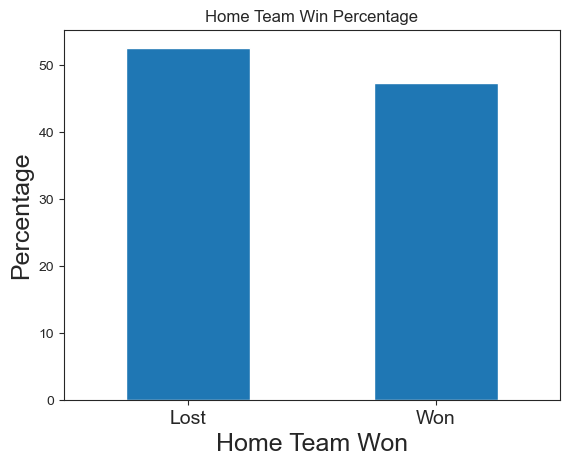

In [234]:
# plot the naive choice df
naive_df = modeling_df['Home_Team_Won'].value_counts(normalize=True) * 100

ax = naive_df.plot.bar()
plt.title('Home Team Win Percentage', size=20)
plt.xlabel('Home Team Won', size=18)
ax.set_xticklabels(['Lost', 'Won'])
plt.xticks(rotation=0, size=14)
plt.ylabel('Percentage', size=18)
plt.show()

A naive choice of picking the home team would be correct 52.66% of the time

In [214]:
# Filter the original df to get the training datasets
X_train = modeling_df.loc[modeling_df['season_id'].isin(['20192020', '20202021', '20212022'])].drop(['season_id', 'Home_Team_Won'], axis=1)
y_train = modeling_df[modeling_df['season_id'].isin(['20192020', '20202021', '20212022'])][['Home_Team_Won']]

# Filter the original df to get the testing datasets
X_test = modeling_df.loc[modeling_df['season_id'] == '20222023'].drop(['season_id', 'Home_Team_Won'], axis=1)
X_test = X_test.iloc[:len(X_test)//2] # First half
y_test = modeling_df[modeling_df['season_id'] == '20222023'].head(len(X_test))[['Home_Team_Won']]

# Filter the original df to get the val/predict holdout set
xval = modeling_df.loc[modeling_df['season_id'] == '20222023'].drop(['season_id', 'Home_Team_Won'], axis=1)
xval = xval.iloc[len(xval)//2:] # Second half of 2023 season feature set
yval = modeling_df[modeling_df['season_id'] == '20222023'].tail(len(xval))[['Home_Team_Won']] 

In [98]:
# Check df shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape) 
print(xval.shape)
print(yval.shape) 

# shapes look good besides needing to get rid the target index

(2583, 24)
(2583, 1)
(572, 24)
(572, 1)
(573, 24)
(573, 1)


In [100]:
# Ravel the target variable
y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()
yval = yval.to_numpy().ravel()

In [101]:
# check post raveling shape
y_train.shape

(2583, )

In [102]:
#check testing feature df
X_test

,home_rolling_avg_FF%,home_rolling_avg_GF%,home_rolling_avg_xGF%,home_rolling_avg_HDCF%,home_rolling_avg_HDSH%,home_rolling_avg_HDSV%,home_rolling_avg_SH%,home_rolling_avg_SV%,home_rolling_avg_GF/60_pp,home_rolling_avg_xGF/60_pp,home_rolling_avg_GA/60_pk,home_rolling_avg_xGA/60_pk,away_rolling_avg_FF%,away_rolling_avg_GF%,away_rolling_avg_xGF%,away_rolling_avg_HDCF%,away_rolling_avg_HDSH%,away_rolling_avg_HDSV%,away_rolling_avg_SH%,away_rolling_avg_SV%,away_rolling_avg_GF/60_pp,away_rolling_avg_xGF/60_pp,away_rolling_avg_GA/60_pk,away_rolling_avg_xGA/60_pk
2583,49.735,32.491,48.908,49.169,22.159,78.927,85.867105,921.038684,9.441,7.785,72.832,11.715,48.947,47.053,47.742,41.625,28.125,85.481,85.716203,900.714684,8.508,8.636,7.972,10.871
2584,48.479,42.886,46.365,40.669,23.827,87.750,85.716203,900.714684,8.508,8.776,6.555,10.918,48.374,39.889,47.923,49.545,23.219,78.927,85.867105,921.038684,9.441,8.654,72.832,12.441
2585,49.208,60.336,48.697,51.544,19.258,85.646,86.972564,919.498718,19.933,14.413,18.013,13.890,50.242,54.916,51.354,51.701,16.677,80.485,94.467733,916.294933,20.109,10.755,13.700,7.023
2586,57.887,60.797,56.150,53.416,20.879,84.844,75.363457,907.509753,2.384,6.310,13.079,7.193,55.063,52.587,53.010,53.342,10.801,78.564,77.844487,918.238462,14.194,13.521,8.787,6.820
2587,54.878,54.828,53.214,51.301,18.036,83.604,83.180380,914.091266,9.506,6.588,9.466,6.175,58.396,60.561,59.474,56.382,20.807,87.330,79.179398,923.919639,8.031,9.234,13.018,10.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150,49.166,45.327,51.517,57.405,19.022,78.673,85.716203,900.714684,14.717,7.732,8.503,6.856,47.900,45.801,44.980,44.280,15.054,79.283,85.357089,911.394430,6.289,3.579,9.051,6.079
3151,39.367,27.818,38.477,33.910,16.775,77.629,82.138816,904.488684,6.575,6.060,6.021,11.031,47.571,44.887,47.900,48.752,7.886,90.607,85.867105,921.038684,6.214,6.832,18.593,11.883
3152,47.871,37.887,48.797,47.587,14.872,84.978,81.882278,921.907468,19.877,10.827,2.215,6.571,55.709,42.178,54.581,55.290,9.622,82.393,91.066104,904.576753,10.453,7.332,10.708,8.438
3153,59.889,62.998,64.091,64.046,16.998,85.923,82.596835,919.507089,5.847,7.321,5.330,6.263,49.287,57.996,49.618,53.461,17.200,91.010,85.016456,913.905316,8.430,9.284,11.831,8.231


- Currently we don't have any categorical features
    - will leave the code for categorical features in in case it's needed in the future
    - pipeline will be instantiated with one hot encoder and max absolute scaling
 - numeric feratures will be standard scaled

In [103]:
# Assign ints and floats to num_features for pipeline
num_features = X_train.select_dtypes(['int', 'float']).columns
# assign object features to cat_features for pipeline
cat_features = X_train.select_dtypes(['object']).columns # no cat features currently fyi

In [125]:
# Establish pipelines for each feature type
numeric_pipeline = Pipeline([('ss', StandardScaler())])

nominal_pipeline = Pipeline([
    ('onehotenc', OneHotEncoder(handle_unknown = 'ignore')), 
    ('onehotnorm', MaxAbsScaler())])

# declare scoring metric list
scoring = ['neg_log_loss', 'accuracy']

# declare random stame value
rnd = 42

In [126]:
# Instantiate the column transformer 
ct = ColumnTransformer(transformers=
    [("numpipe", numeric_pipeline, num_features),
     ("nominalpipe", nominal_pipeline, cat_features)])

### Basic Logistic Regression

In [47]:
# build baseline log reg pipepline 
steps = [('preprocess', ct), 
         ('logreg', LogisticRegression(random_state = rnd, max_iter=10000))]

base_log_reg_pipeline = Pipeline(steps)

base_log_reg_pipeline.fit(X_train, y_train)

# Predict using the pipeline 
base_log_y_pred = base_log_reg_pipeline.predict(X_test)

In [48]:
# code block for getting scores, just need to change the pred and prob_a var for each metric line
# Evaluate the accuracy of the predictions
accuracy = accuracy_score(y_test, base_log_y_pred)
print(f'Test accuracy: {accuracy:.3f}')

# Calculate the F1 score for the test set
f1 = f1_score(y_test, base_log_y_pred,average='macro')
print(f'Test F1 score: {f1:.3f}')

# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')

# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')

Test accuracy: 0.579
Test F1 score: 0.577
Test AUC-ROC score: 0.621
Test log loss score: 0.665


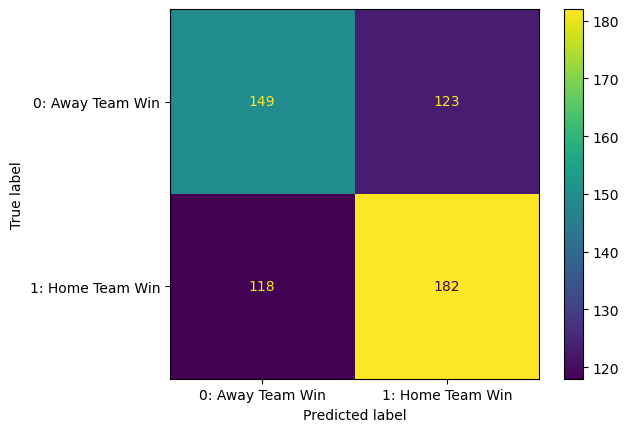

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.55      0.55       272
           1       0.60      0.61      0.60       300

    accuracy                           0.58       572
   macro avg       0.58      0.58      0.58       572
weighted avg       0.58      0.58      0.58       572

Test log loss score: 0.665
Test AUC-ROC score: 0.621


In [49]:
# Alternately we can just next the classification report and scores underneath the confusion matrix in this single block

# Calculate the confusion matrix
label_names = ['0: Away Team Win', '1: Home Team Win']
cm = confusion_matrix(y_test, base_log_y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, base_log_y_pred)
print(f'Classification report:\n{report}')
# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')# Calculate the AUC-ROC score for the test set
# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')

## Model Grid Searches

### Logistic Regression Grid Search

In [50]:
# set up grid search
# pipeline steps remain the same
steps = [('preprocess', ct), 
         ('logreg', LogisticRegression(random_state=42, max_iter=10000))]

log_cv_pipeline = Pipeline(steps)

log_cv_params = {'logreg__solver' : ['liblinear', 'lbfgs', 'newton-cg'],
                'logreg__penalty': ['None', 'l1', 'l2'],
                'logreg__C': [0.1, 10, 20, 100],
                'logreg__class_weight': [None] }

log_cv = GridSearchCV(log_cv_pipeline, param_grid=log_cv_params, cv=5, scoring=scoring, 
                      refit = 'neg_log_loss', verbose=1)

while some params are not compatible with each other, the below cv will still run and provide results for 

In [51]:
# fit on the training data
log_cv.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/jamesbenasuli/miniforge3/envs/tf-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jamesbenasuli/miniforge3/envs/tf-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jamesbenasuli/miniforge3/envs/tf-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jamesbenasuli/miniforge3/envs/tf-env/lib/python3.8/site

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['home_rolling_avg_FF%', 'home_rolling_avg_GF%', 'home_rolling_avg_xGF%',
       'home_rolling_avg_HDCF%', 'home_rolling_avg_HDSH%',
       'home_rolling_avg_HDSV%', 'home_rolling_avg_SH%',
       'home_rolling_avg_SV%', 'home_rol...
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         Index([], dtype='object'))])),
                                       ('logreg',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42))]),
             param_grid={'logreg__C': [0.1, 10, 20, 100],
                         'logreg__class_weight': [None],
                         'logreg__penalty': ['None', 'l1', 'l2'],
                         'logreg__solver': ['liblinear', 'lbfgs', 'newton-cg']},
             refit='neg_log_loss', scoring=['neg_log_loss', 'accuracy'],
             verbose=1)

In [52]:
# displaying the best score
log_cv.best_score_

-0.6560619419520151

In [53]:
# store LogReg CV results in a df
log_results = pd.DataFrame(log_cv.cv_results_).sort_values('mean_test_neg_log_loss', ascending=False)
log_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_logreg__class_weight,param_logreg__penalty,param_logreg__solver,params,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
3,0.007079,0.002108,0.002384,0.000225,0.1,None,l1,liblinear,"{'logreg__C': 0.1, 'logreg__class_weight': Non...",-0.672428,-0.654490,-0.654427,-0.652795,-0.646170,-0.656062,0.008735,1,0.578337,0.618956,0.589942,0.618217,0.637597,0.608610,0.021469,1
6,0.004669,0.000335,0.002140,0.000017,0.1,None,l2,liblinear,"{'logreg__C': 0.1, 'logreg__class_weight': Non...",-0.677302,-0.655802,-0.657348,-0.655178,-0.644697,-0.658065,0.010609,2,0.584139,0.615087,0.582205,0.610465,0.633721,0.605123,0.019551,14
7,0.006881,0.000728,0.002321,0.000134,0.1,None,l2,lbfgs,"{'logreg__C': 0.1, 'logreg__class_weight': Non...",-0.677305,-0.655821,-0.657367,-0.655166,-0.644680,-0.658068,0.010614,3,0.584139,0.617021,0.582205,0.608527,0.633721,0.605123,0.019680,15
8,0.011612,0.000419,0.002242,0.000032,0.1,None,l2,newton-cg,"{'logreg__C': 0.1, 'logreg__class_weight': Non...",-0.677304,-0.655824,-0.657371,-0.655165,-0.644679,-0.658069,0.010614,4,0.584139,0.617021,0.582205,0.608527,0.633721,0.605123,0.019680,15
12,0.010378,0.001126,0.002266,0.000080,10,None,l1,liblinear,"{'logreg__C': 10, 'logreg__class_weight': None...",-0.679819,-0.656302,-0.657768,-0.655881,-0.644118,-0.658778,0.011603,5,0.584139,0.611219,0.582205,0.610465,0.641473,0.605900,0.021677,2
21,0.009655,0.001676,0.002148,0.000047,20,None,l1,liblinear,"{'logreg__C': 20, 'logreg__class_weight': None...",-0.679897,-0.656338,-0.657807,-0.655931,-0.644113,-0.658817,0.011628,6,0.584139,0.611219,0.582205,0.610465,0.639535,0.605513,0.021046,3
30,0.009634,0.001651,0.002162,0.000030,100,None,l1,liblinear,"{'logreg__C': 100, 'logreg__class_weight': Non...",-0.679960,-0.656368,-0.657842,-0.655971,-0.644109,-0.658850,0.011648,7,0.584139,0.611219,0.582205,0.610465,0.639535,0.605513,0.021046,3
15,0.004853,0.000343,0.002114,0.000026,10,None,l2,liblinear,"{'logreg__C': 10, 'logreg__class_weight': None...",-0.679951,-0.656370,-0.657851,-0.655981,-0.644115,-0.658853,0.011643,8,0.584139,0.611219,0.582205,0.610465,0.639535,0.605513,0.021046,3
17,0.011922,0.000767,0.002169,0.000023,10,None,l2,newton-cg,"{'logreg__C': 10, 'logreg__class_weight': None...",-0.679952,-0.656370,-0.657852,-0.655981,-0.644114,-0.658854,0.011643,9,0.584139,0.611219,0.582205,0.610465,0.639535,0.605513,0.021046,3
16,0.007231,0.000199,0.002107,0.000030,10,None,l2,lbfgs,"{'logreg__C': 10, 'logreg__class_weight': None...",-0.679952,-0.656370,-0.657853,-0.655980,-0.644115,-0.658854,0.011643,10,0.584139,0.611219,0.582205,0.610465,0.639535,0.605513,0.021046,3


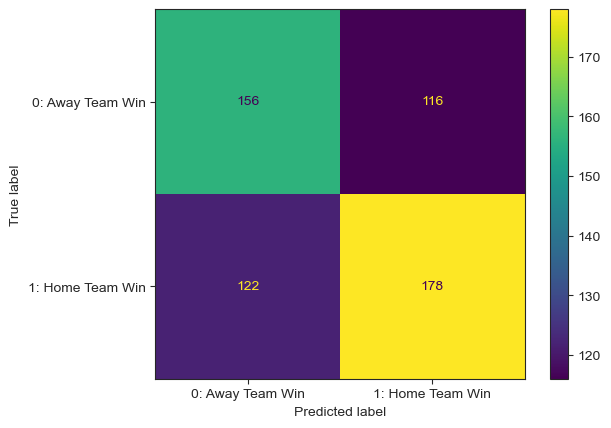

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.57      0.57       272
           1       0.61      0.59      0.60       300

    accuracy                           0.58       572
   macro avg       0.58      0.58      0.58       572
weighted avg       0.58      0.58      0.58       572

Test log loss score: 0.661
Test AUC-ROC score: 0.630


In [192]:
# Calculate the confusion matrix
label_names = ['0: Away Team Win', '1: Home Team Win']
cm = confusion_matrix(y_test, log_cv.predict(X_test))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, log_cv.predict(X_test))
print(f'Classification report:\n{report}')
# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, log_cv.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')# Calculate the AUC-ROC score for the test set
# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, log_cv.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')

### Gradient Boosting Classifier Grid Search

In [57]:
# Instantiate GB pipeline and set param grid for grid search
gb_pipeline = Pipeline(steps=[('preprocess', ct),
                      ('gb', GradientBoostingClassifier(random_state=rnd))])

gb_params = {'gb__n_estimators': [200, 300, 400],
         'gb__learning_rate': [.001,.01, .1],
         'gb__max_depth' : [3,5]}

gb_cv = GridSearchCV(gb_pipeline, param_grid=gb_params, cv=5, scoring=scoring, refit='neg_log_loss', verbose=1)

In [58]:
# fit on the train data
gb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['home_rolling_avg_FF%', 'home_rolling_avg_GF%', 'home_rolling_avg_xGF%',
       'home_rolling_avg_HDCF%', 'home_rolling_avg_HDSH%',
       'home_rolling_avg_HDSV%', 'home_rolling_avg_SH%',
       'home_rolling_avg_SV%', 'home_rol...
                                                                         Pipeline(steps=[('onehotenc',
                                                                                          OneHotEncoder(handle_unknown='ignore')),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         Index([], dtype='object'))])),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'gb__learning_rate': [0.001, 0.01, 0.1],
                         'gb__max_depth': [3, 5],
                         'gb__n_estimators': [200, 300, 400]},
             refit='neg_log_loss', scoring=['neg_log_loss', 'accuracy'],
             verbose=1)

In [59]:
# display the best gradient boost score
gb_cv.best_score_

-0.6616890331615158

In [60]:
# store the gb cv results in a df
gb_results = pd.DataFrame(gb_cv.cv_results_).sort_values('mean_test_neg_log_loss', ascending=False)
gb_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gb__learning_rate,param_gb__max_depth,param_gb__n_estimators,params,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
8,3.756433,0.036516,0.007615,0.000226,0.01,3,400,"{'gb__learning_rate': 0.01, 'gb__max_depth': 3...",-0.670905,-0.662275,-0.664357,-0.642580,-0.668328,-0.661689,0.010016,1,0.605416,0.605416,0.599613,0.645349,0.593023,0.609763,0.018371,2
7,2.773285,0.013670,0.006606,0.000170,0.01,3,300,"{'gb__learning_rate': 0.01, 'gb__max_depth': 3...",-0.673782,-0.663149,-0.663088,-0.643709,-0.668116,-0.662369,0.010125,2,0.588008,0.609284,0.609284,0.647287,0.598837,0.610540,0.019991,1
6,1.846811,0.013085,0.005555,0.000188,0.01,3,200,"{'gb__learning_rate': 0.01, 'gb__max_depth': 3...",-0.674430,-0.668417,-0.664900,-0.649758,-0.669236,-0.665348,0.008370,3,0.584139,0.593810,0.605416,0.651163,0.593023,0.605510,0.023806,3
9,2.962415,0.013117,0.007626,0.000602,0.01,5,200,"{'gb__learning_rate': 0.01, 'gb__max_depth': 5...",-0.678398,-0.667134,-0.669745,-0.648703,-0.678339,-0.668464,0.010864,4,0.558994,0.605416,0.593810,0.635659,0.563953,0.591567,0.028158,6
10,4.471841,0.024658,0.009224,0.000668,0.01,5,300,"{'gb__learning_rate': 0.01, 'gb__max_depth': 5...",-0.677326,-0.668275,-0.675631,-0.649841,-0.681277,-0.670470,0.011143,5,0.576402,0.605416,0.586074,0.625969,0.587209,0.596214,0.017587,4
11,6.049527,0.087589,0.010790,0.000209,0.01,5,400,"{'gb__learning_rate': 0.01, 'gb__max_depth': 5...",-0.676643,-0.669239,-0.680921,-0.652746,-0.686477,-0.673205,0.011677,6,0.580271,0.605416,0.580271,0.631783,0.577519,0.595052,0.020981,5
5,5.863800,0.085167,0.010243,0.000494,0.001,5,400,"{'gb__learning_rate': 0.001, 'gb__max_depth': ...",-0.684045,-0.680626,-0.673393,-0.671054,-0.681252,-0.678074,0.004969,7,0.549323,0.562863,0.586074,0.624031,0.579457,0.580350,0.025338,9
4,4.392570,0.057059,0.008055,0.000369,0.001,5,300,"{'gb__learning_rate': 0.001, 'gb__max_depth': ...",-0.684866,-0.682472,-0.675911,-0.674883,-0.682505,-0.680128,0.003972,8,0.535783,0.568665,0.580271,0.606589,0.591085,0.576479,0.023881,10
2,3.608833,0.030395,0.007500,0.000386,0.001,3,400,"{'gb__learning_rate': 0.001, 'gb__max_depth': ...",-0.683014,-0.681881,-0.680234,-0.674710,-0.681874,-0.680343,0.002952,9,0.566731,0.572534,0.555126,0.604651,0.569767,0.573762,0.016543,12
1,2.691835,0.018407,0.006160,0.000223,0.001,3,300,"{'gb__learning_rate': 0.001, 'gb__max_depth': ...",-0.684309,-0.683600,-0.682430,-0.677987,-0.683452,-0.682355,0.002265,10,0.568665,0.558994,0.549323,0.604651,0.567829,0.569893,0.018739,13


### AdaBoost Classifier Grid Search

In [129]:
# Instantiate AdaBoostClassifier pipeline and set param grid
ada_pipeline = Pipeline(steps=[('preprocess', ct),
                      ('ada', AdaBoostClassifier(random_state=rnd))])

# AdaBoost param grid includes SVM/LogReg for estimator
ada_params = {'ada__n_estimators': [25, 50],
         'ada__learning_rate': [.1, 1, 10, 20],
         'ada__base_estimator': [svm.SVC(probability=True , kernel='linear'), LogisticRegression()],}

ada_cv = GridSearchCV(ada_pipeline, param_grid=ada_params, cv=5, scoring=scoring, refit='neg_log_loss', verbose=1)

In [130]:
# fit on the raining data
ada_cv.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['home_rolling_avg_FF%', 'home_rolling_avg_GF%', 'home_rolling_avg_xGF%',
       'home_rolling_avg_HDCF%', 'home_rolling_avg_HDSH%',
       'home_rolling_avg_HDSV%', 'home_rolling_avg_SH%',
       'home_rolling_avg_SV%', 'home_rol...
                                                                                          OneHotEncoder(handle_unknown='ignore')),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         Index([], dtype='object'))])),
                                       ('ada',
                                        AdaBoostClassifier(random_state=42))]),
             param_grid={'ada__base_estimator': [SVC(kernel='linear',
                                                     probability=True),
                                                 LogisticRegression()],
                         'ada__learning_rate': [0.1, 1, 10, 20],
                         'ada__n_estimators': [25, 50]},
             refit='neg_log_loss', scoring=['neg_log_loss', 'accuracy'],
             verbose=1)

In [131]:
# display the best score
ada_cv.best_score_

-0.6709999577464733

In [132]:
# store the adaboost cv results in a df
ada_results = pd.DataFrame(ada_cv.cv_results_).sort_values('mean_test_neg_log_loss', ascending=False)
ada_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ada__base_estimator,param_ada__learning_rate,param_ada__n_estimators,params,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,16.209140,0.308196,1.256776,0.149910,"SVC(kernel='linear', probability=True)",0.1,25,"{'ada__base_estimator': SVC(kernel='linear', p...",-0.674094,-0.672129,-0.670664,-0.668098,-0.670015,-0.671000,0.002018,1,0.589942,0.613153,0.593810,0.624031,0.633721,0.610931,0.016909,1
8,0.064263,0.003294,0.007103,0.000271,LogisticRegression(),0.1,25,"{'ada__base_estimator': LogisticRegression(), ...",-0.681232,-0.679472,-0.676975,-0.676454,-0.676919,-0.678211,0.001844,2,0.564797,0.589942,0.597679,0.614341,0.645349,0.602422,0.026753,5
4,16.195425,0.076233,1.217250,0.001756,"SVC(kernel='linear', probability=True)",10,25,"{'ada__base_estimator': SVC(kernel='linear', p...",-0.684480,-0.675855,-0.680933,-0.678199,-0.677054,-0.679305,0.003086,3,0.541586,0.576402,0.595745,0.596899,0.620155,0.586157,0.026248,7
1,31.615268,0.071517,2.309478,0.007129,"SVC(kernel='linear', probability=True)",0.1,50,"{'ada__base_estimator': SVC(kernel='linear', p...",-0.681155,-0.680464,-0.679646,-0.677685,-0.679658,-0.679722,0.001163,4,0.595745,0.574468,0.578337,0.608527,0.593023,0.590020,0.012350,6
3,30.989938,2.484055,2.272117,0.229787,"SVC(kernel='linear', probability=True)",1,50,"{'ada__base_estimator': SVC(kernel='linear', p...",-0.687483,-0.681919,-0.671081,-0.672323,-0.688831,-0.680327,0.007425,5,0.539652,0.531915,0.593810,0.575581,0.527132,0.553618,0.026326,9
2,15.505107,0.855975,1.128918,0.075806,"SVC(kernel='linear', probability=True)",1,25,"{'ada__base_estimator': SVC(kernel='linear', p...",-0.687279,-0.682295,-0.671518,-0.673625,-0.687603,-0.680464,0.006746,6,0.529981,0.535783,0.584139,0.587209,0.527132,0.552849,0.026964,10
9,0.118752,0.000961,0.010595,0.000154,LogisticRegression(),0.1,50,"{'ada__base_estimator': LogisticRegression(), ...",-0.683938,-0.682916,-0.681424,-0.680727,-0.681550,-0.682111,0.001157,7,0.574468,0.605416,0.599613,0.622093,0.645349,0.609388,0.023602,3
5,32.025751,0.191586,2.418920,0.017951,"SVC(kernel='linear', probability=True)",10,50,"{'ada__base_estimator': SVC(kernel='linear', p...",-0.687390,-0.677648,-0.685366,-0.681357,-0.680992,-0.682551,0.003442,8,0.545455,0.570600,0.555126,0.589147,0.594961,0.571058,0.019017,8
6,15.884293,0.237579,1.194349,0.028934,"SVC(kernel='linear', probability=True)",20,25,"{'ada__base_estimator': SVC(kernel='linear', p...",-0.688918,-0.680231,-0.687403,-0.678030,-0.687328,-0.684382,0.004381,9,0.549323,0.555126,0.526112,0.587209,0.527132,0.548980,0.022359,11
7,31.697856,0.592158,2.369736,0.066990,"SVC(kernel='linear', probability=True)",20,50,"{'ada__base_estimator': SVC(kernel='linear', p...",-0.690266,-0.685419,-0.689436,-0.682070,-0.689462,-0.687331,0.003128,10,0.526112,0.539652,0.528046,0.598837,0.527132,0.543956,0.027875,12


### Neural Network Grid Search

In [61]:
# Instantiate NN model
def build_model(optimizer='adam', activation='linear', neurons = 36, dropout_rate=0.3, weight_constraint=3):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_dim=24, kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    #Hidden layer 
    model.add(Dense(4, activation=activation))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# define the grid search parameters

param_grid = {'nn__epochs': [8, 10, 12],
             'nn__optimizer' : ['Adam'], 
             'nn__activation' : ['sigmoid', 'linear'],
            'nn__neurons' : [12, 18, 24, 30, 36],
             'nn__weight_constraint': [1, 3, 5],
             'nn__dropout_rate' : [0.0, 0.3, 0.6,]}

#wrap neural network in scikit learn wrapper
keras_model = scikit_learn.KerasClassifier(build_fn=build_model, verbose=0)

steps = [('preprocess', ct), 
        ('nn', keras_model)]

nn_pipeline = Pipeline(steps)

nn_cv = GridSearchCV(estimator=nn_pipeline, param_grid=param_grid, cv=2, scoring=scoring, refit='neg_log_loss', verbose=1)

In [62]:
nn_cv.fit(X_train, y_train)

Fitting 2 folds for each of 270 candidates, totalling 540 fits
Metal device set to: Apple M1


2023-04-19 10:10:41.451996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-19 10:10:41.452895: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-19 10:10:41.649668: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-19 10:10:41.813466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:10:44.420765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:10:44.749546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:10:46.810586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:10:47.134490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:10:49.219812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:10:49.544269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:10:51.585478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:10:51.911344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:10:53.994408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:10:54.312283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:10:56.406441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:10:56.765668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:10:58.943780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:10:59.349514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:11:01.566910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:01.889591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:11:04.085700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:04.411909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:11:06.606081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:06.939737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:11:09.128176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:09.460290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:11:11.681499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:12.037882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:11:14.316540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:14.659982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:11:16.930043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:17.252376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:11:19.581538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:20.674886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:11:22.836131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:23.158769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:11:25.356674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:25.686203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:11:27.907113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:28.253378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:11:30.520464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:30.857381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:11:33.109469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:33.443229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:11:35.769143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:36.092746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:11:38.356008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:38.689527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:11:40.940284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:41.268402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:11:43.521154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:43.881050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:11:46.234948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:46.572517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:11:48.936361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:49.272969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:11:51.669693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:52.007008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:11:54.400566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:54.738623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:11:57.194025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:11:57.530674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:11:59.925794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:12:00.268106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:12:03.130735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:12:03.474895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:12:06.297302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:12:06.638916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:12:09.516474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:12:09.855960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:12:12.667212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:12:13.011031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/41 [========================>.....] - ETA: 0s

2023-04-19 10:12:15.874256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:12:16.223929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:12:19.204237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:12:19.543990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:12:22.528590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:12:22.871629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:12:25.883675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:12:26.226714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/41 [========================>.....] - ETA: 0s

2023-04-19 10:12:29.325445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:12:29.680061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:12:32.720543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:12:33.087242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:12:36.184874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:12:37.795831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/41 [========================>.....] - ETA: 0s

2023-04-19 10:12:40.721576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:12:41.069408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:12:43.970469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:12:44.306707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/41 [========================>.....] - ETA: 0s

2023-04-19 10:12:47.146195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:12:47.494070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/41 [========================>.....] - ETA: 0s

2023-04-19 10:12:50.413710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:12:50.759964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/41 [=========================>....] - ETA: 0s

2023-04-19 10:12:53.739402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:12:54.085696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:12:57.162270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:12:57.503822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:13:00.481019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:13:00.825905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/41 [========================>.....] - ETA: 0s

2023-04-19 10:13:03.909719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:13:04.263262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/41 [=======================>......] - ETA: 0s

2023-04-19 10:13:07.332635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:13:07.691033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/41 [=========================>....] - ETA: 0s

2023-04-19 10:13:10.792051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:13:11.146035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:13:14.459010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:13:14.813926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:13:17.976940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:13:18.344440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:13:21.472692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:13:21.823664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:13:24.939482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:13:25.298608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:13:28.531337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:13:28.893086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:13:32.011793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:13:32.348605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:13:35.411781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:13:35.769029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:13:38.905633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:13:39.278783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:13:42.424586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:13:42.795037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:13:46.217465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:13:46.585544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:13:50.143147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:13:50.506031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:13:54.114357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:13:54.469877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:13:58.069066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:13:58.433209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:14:02.001093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:14:02.367882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:14:06.042991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:14:06.408457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:14:10.074194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:14:10.440416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:14:14.440785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:14:16.573281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/41 [=======================>......] - ETA: 0s

2023-04-19 10:14:20.232291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:14:20.592688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:14:24.183990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:14:24.551035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:14:28.118218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:14:28.485604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:14:32.135913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:14:32.500150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/41 [=======================>......] - ETA: 0s

2023-04-19 10:14:36.208959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:14:36.564927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:14:40.290579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:14:40.670043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:14:44.362896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:14:44.726551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:14:48.448005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:14:48.812996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:14:52.366313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:14:52.736170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/41 [=======================>......] - ETA: 0s

2023-04-19 10:14:56.443253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:14:56.807094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:15:00.467965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:15:00.841255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/41 [========================>.....] - ETA: 0s

2023-04-19 10:15:04.618746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:15:04.967825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:15:08.654153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:15:09.018399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:15:12.791387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:15:13.158866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:15:16.912090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:15:17.273034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:15:20.951323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:15:21.343355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:15:25.049155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:15:25.404517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/41 [========================>.....] - ETA: 0s

2023-04-19 10:15:28.990401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:15:29.342401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:15:32.977732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:15:33.342146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:15:36.910629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:15:37.277850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:15:40.931745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:15:41.264249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:15:44.871752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:15:45.241002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:15:48.250346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:15:48.617039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:15:51.603135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:15:51.978141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/41 [========================>.....] - ETA: 0s

2023-04-19 10:15:54.901059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:15:55.260692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:15:58.183044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:16:00.489389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:16:03.550625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:16:03.939357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/41 [=======================>......] - ETA: 0s

2023-04-19 10:16:06.911815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:16:07.276423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:16:10.243758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:16:10.612422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:16:13.482466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:16:13.845933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/41 [=======================>......] - ETA: 0s

2023-04-19 10:16:16.752679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:16:17.109982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/41 [=======================>......] - ETA: 0s

2023-04-19 10:16:20.135737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:16:20.493501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/41 [========================>.....] - ETA: 0s

2023-04-19 10:16:23.523810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:16:23.881662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:16:26.754077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:16:27.099527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:16:30.045770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:16:30.407851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:16:33.343342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:16:33.710290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:16:36.720126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:16:37.083739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:16:39.928839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:16:40.294567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:16:43.222029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:16:43.582531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:16:46.554177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:16:46.936529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:16:49.796926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:16:50.159459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:16:52.962533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:16:53.310152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:16:56.396657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:16:56.794141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:17:00.005508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:17:00.353141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:17:03.286844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-19 10:17:03.640282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:17:06.611279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:17:06.988560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:17:09.965227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:17:10.336528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:17:13.568151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:17:13.963880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:17:17.271310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:17:17.683671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:17:20.903263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:17:21.300457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:17:24.608050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:17:27.148486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:17:30.384508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:17:30.763523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:17:34.431367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:17:34.833330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:17:38.701970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:17:39.105260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:17:42.732522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:17:43.101526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:17:46.822056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:17:47.219801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:17:50.974292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:17:51.375046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:17:55.093716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:17:55.469450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:17:59.343232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:17:59.724421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:18:03.567268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:18:03.964630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:18:07.858379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:18:08.256676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:18:12.124503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:18:12.507087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:18:16.393282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:18:16.770809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:18:20.553149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:18:20.950415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:18:24.674532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:18:25.070065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:18:28.891047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:18:29.284625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:18:32.902284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:18:33.297762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:18:37.239825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:18:37.610471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:18:41.167575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:18:41.540711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:18:45.182580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:18:45.559225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:18:49.547255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:18:49.960277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:18:53.719746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:18:54.098233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:18:57.969789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:18:58.390280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:19:02.213359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:19:02.582054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:19:06.623949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:19:07.038798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:19:10.942760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:19:11.316313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:19:15.420614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:19:18.148496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:19:22.227143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:19:22.639388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:19:26.355692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:19:26.733904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:19:30.737364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:19:31.131087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:19:35.113288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:19:35.514353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:19:39.681124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:19:40.078764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:19:44.644129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:19:45.052293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:19:49.634447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:19:50.033230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:19:54.316298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:19:54.723939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:19:59.258360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:19:59.671946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:20:04.253913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:20:04.655403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:20:09.207677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:20:09.600239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:20:14.279721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:20:14.692614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:20:19.276996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:20:19.675469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:20:23.952158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:20:24.351399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:20:28.760282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:20:29.169453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:20:33.497814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:20:33.881848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:20:38.372720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:20:38.750443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:20:43.322052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:20:43.746323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:20:48.222922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:20:48.625914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:20:53.120971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:20:53.531904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:20:58.039790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:20:58.465090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:21:03.000336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:21:03.374236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:21:07.942390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:21:08.337626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:21:13.227375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:21:13.637730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:21:18.222005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:21:18.636607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:21:23.065753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:21:25.834075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:21:30.659510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:21:31.078387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:21:35.797427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:21:36.207123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:21:40.951740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:21:41.381065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:21:46.014182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:21:46.425685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:21:51.155698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:21:51.567771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:21:55.989274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:21:56.401419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:22:01.135121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:22:01.535073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:22:06.087735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:22:06.486516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:22:11.304574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:22:11.726201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:22:15.477606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:22:15.901077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:22:19.389764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:22:19.804737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:22:23.507750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:22:23.895540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:22:27.382531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:22:27.806646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:22:31.427506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:22:31.837465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:22:35.499749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:22:35.912077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:22:39.486794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:22:39.889912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:22:43.498019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:22:43.904493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:22:47.695730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:22:48.121219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:22:51.709910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:22:52.127153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:22:55.833397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:22:56.242319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:22:59.889797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:23:00.335965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:23:04.019778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:23:04.437290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:23:08.063254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:23:08.481934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:23:12.368477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:23:12.792079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:23:16.516598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:23:19.150911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:23:23.087326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:23:23.514063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:23:27.369524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:23:27.795064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:23:31.372581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:23:31.778378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:23:35.481812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:23:35.922404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:23:39.592919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:23:40.019094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:23:43.668123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:23:44.104703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:23:47.884708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:23:48.306961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:23:52.017004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:23:52.440796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:23:56.301114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:23:56.733701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:24:00.433877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:24:00.862432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:24:04.679610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:24:05.094497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:24:08.733981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:24:09.150364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:24:12.803600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:24:13.240648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:24:16.947821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:24:17.391211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:24:21.576887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:24:22.001749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:24:26.365330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:24:26.795596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:24:31.040458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:24:31.477842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:24:35.699215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:24:36.108929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:24:40.325200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:24:40.743270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step


2023-04-19 10:24:44.961439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:24:45.390486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:24:49.701037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:24:50.123847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:24:54.280297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:24:54.719342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:24:58.857133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:24:59.299556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:25:03.588653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:25:04.013645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:25:08.261228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:25:10.990481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:25:15.829595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:25:16.264021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:25:20.637637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:25:21.065399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - ETA: 0s

2023-04-19 10:25:25.305367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:25:25.755047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:25:30.053114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:25:30.473305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:25:34.757761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:25:35.192805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:25:39.553445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:25:39.992383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:25:44.284071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:25:44.710786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:25:49.095582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:25:49.517272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:25:53.752147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:25:54.183579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:25:58.391566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:25:58.796150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:26:03.023414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:26:03.441904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:26:07.849360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:26:08.282987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:26:12.772936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:26:13.203125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:26:17.694856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:26:18.126220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:26:22.556994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:26:22.992139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:26:27.227993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:26:27.660790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:26:31.909029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:26:32.319117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:26:36.719542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:26:37.171147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:26:41.711046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:26:42.147935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/41 [==============>...............] - ETA: 0s

2023-04-19 10:26:47.181414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:26:47.632275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/41 [===============>..............] - ETA: 0s

2023-04-19 10:26:52.677760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:26:53.129951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:26:58.094325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:26:58.525099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/41 [=================>............] - ETA: 0s

2023-04-19 10:27:03.521930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:27:03.976791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/41 [===============>..............] - ETA: 0s

2023-04-19 10:27:09.188233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:27:09.649943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/41 [=================>............] - ETA: 0s

2023-04-19 10:27:14.967738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:27:15.423937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 7s

2023-04-19 10:27:22.806711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:27:23.538211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:27:29.041631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:27:29.478637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:27:34.719294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:27:35.148264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:27:40.520838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:27:40.929975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:27:46.238080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:27:46.667889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/41 [==================>...........] - ETA: 0s

2023-04-19 10:27:51.765102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:27:52.258732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:27:57.289176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:27:57.717737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:28:03.007414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:28:03.444966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/41 [=================>............] - ETA: 0s

2023-04-19 10:28:08.823357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:28:09.337485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:28:14.741236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:28:15.180893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:28:20.638799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:28:21.101573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:28:26.421140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:28:26.871003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/41 [===============>..............] - ETA: 0s

2023-04-19 10:28:32.236887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:28:32.679850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/41 [===============>..............] - ETA: 0s

2023-04-19 10:28:38.275162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:28:38.771251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - ETA: 0s

2023-04-19 10:28:44.160309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:28:44.613476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:28:49.757664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:28:50.196948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:28:55.934235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:28:56.383130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:29:02.032318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:29:02.468359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:29:07.385430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:29:07.809488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:29:13.313311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:29:13.764713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:29:19.183357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:29:19.639425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:29:25.420205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:29:25.862363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/41 [=================>............] - ETA: 0s

2023-04-19 10:29:31.410456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:29:31.924100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:29:37.281559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:29:37.720529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step


2023-04-19 10:29:41.919645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:29:42.346854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - ETA: 0s

2023-04-19 10:29:46.202058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:29:46.639992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 1:41

2023-04-19 10:29:52.798276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:29:53.476638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:29:57.684175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:29:58.080364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:30:02.198446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:30:02.596419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:30:06.585359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:30:06.955559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:30:10.849509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:30:11.280544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:30:15.000481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:30:15.411549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step


2023-04-19 10:30:19.346043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:30:19.769688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:30:23.614759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:30:24.003676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - ETA: 0s

2023-04-19 10:30:27.936039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:30:28.375763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:30:32.276343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:30:32.662233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:30:36.774001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:30:37.163785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:30:40.684301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:30:41.077868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:30:44.585619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:30:44.975758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:30:48.477295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:30:48.867002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:30:52.444580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:30:52.841530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:30:56.444990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:30:56.822030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:31:00.329944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:31:00.730857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:31:05.389904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:31:05.861433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/41 [===============>..............] - ETA: 0s

2023-04-19 10:31:10.629747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:31:11.095053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:31:15.467913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:31:15.892233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:31:20.647697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:31:21.077192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:31:25.554904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:31:25.970414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:31:30.487494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:31:30.906713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:31:35.430111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:31:35.875027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/41 [===============>..............] - ETA: 0s

2023-04-19 10:31:40.587163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:31:41.071434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:31:45.853900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:31:46.353520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:31:51.162231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:31:51.663132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:31:56.556609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step


2023-04-19 10:31:59.249441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:32:05.295006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:32:05.703656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:32:11.155814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:32:11.602916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:32:16.770279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:32:17.202953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:32:22.810630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:32:23.248911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:32:28.812621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:32:29.209617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:32:34.081154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:32:34.514025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:32:39.521777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:32:40.019716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:32:45.310308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:32:45.774756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:32:51.110965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:32:51.602137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/41 [===============>..............] - ETA: 0s

2023-04-19 10:32:56.941669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:32:57.435388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:33:02.372765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:33:02.847513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:33:07.809366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:33:08.249065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:33:13.534037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:33:13.952414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:33:19.180783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:33:19.611313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:33:24.408587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:33:24.833897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/41 [=================>............] - ETA: 0s

2023-04-19 10:33:30.350362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:33:30.841726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:33:36.356022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:33:36.762079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:33:42.282062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:33:42.860796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:33:48.355878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:33:48.841713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/41 [===============>..............] - ETA: 0s

2023-04-19 10:33:54.299359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:33:54.792950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:34:00.585191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:34:01.053634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:34:06.491399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:34:06.969444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:34:12.696173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:34:13.196597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:34:19.152546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:34:19.631319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:34:25.149809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:34:25.612855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:34:31.195314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:34:31.648444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:34:37.319689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:34:40.088976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/41 [=================>............] - ETA: 0s

2023-04-19 10:34:45.295701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:34:45.775589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/41 [=================>............] - ETA: 0s

2023-04-19 10:34:50.987209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:34:51.456940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:34:57.158632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:34:57.623813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:35:04.218499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:35:04.675760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:35:10.759730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:35:11.282640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:35:18.073988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:35:18.555335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:35:25.083114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:35:25.541871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:35:31.223619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:35:31.631889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:35:38.207614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:35:38.688984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/41 [===================>..........] - ETA: 0s

2023-04-19 10:35:44.984057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:35:45.541049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:35:52.454716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:35:52.936573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:35:59.213592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:35:59.689670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:36:06.487890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:36:06.906965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/41 [===============>..............] - ETA: 0s

2023-04-19 10:36:13.474711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:36:13.939110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/41 [=======================>......] - ETA: 0s

2023-04-19 10:36:19.854729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:36:20.375762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:36:27.118420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:36:27.557985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:36:34.284720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:36:34.710822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:36:41.503888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:36:41.986972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:36:47.822431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:36:48.304939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:36:54.430608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:36:54.853585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:37:01.216051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:37:01.750016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:37:08.343058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:37:08.826608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:37:15.633203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:37:16.106490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/41 [============================>.] - ETA: 0s

2023-04-19 10:37:22.718443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:37:23.219837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:37:29.851149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:37:30.329741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/41 [===============>..............] - ETA: 0s

2023-04-19 10:37:37.042474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:37:37.515586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/41 [=========>....................] - ETA: 0s

2023-04-19 10:37:44.182528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:37:47.051738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:37:53.967552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:37:54.391552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:38:00.856224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:38:01.350563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/41 [============>.................] - ETA: 0s

2023-04-19 10:38:07.940840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:38:08.415375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:38:15.223530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:38:15.744129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:38:22.506561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:38:22.934764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/41 [===============>..............] - ETA: 0s

2023-04-19 10:38:29.551608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:38:30.050431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:38:36.135547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:38:36.653805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:38:43.353626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:38:43.829863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/41 [===============>..............] - ETA: 0s

2023-04-19 10:38:49.967679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:38:50.467703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:38:57.089948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:38:57.533995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:39:03.820792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:39:04.323107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/41 [==============>...............] - ETA: 0s

2023-04-19 10:39:10.643295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:39:11.142565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:39:17.026984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:39:17.572670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:39:23.247599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:39:23.664088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:39:29.770856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:39:30.276687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:39:36.958680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:39:37.480050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/41 [==========================>...] - ETA: 0s

2023-04-19 10:39:43.634239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 6ms/step


2023-04-19 10:39:44.346533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:39:51.032604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:39:51.555518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:39:58.535506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:39:59.060205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/41 [===============>..............] - ETA: 0s

2023-04-19 10:40:05.077524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:40:05.578972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:40:12.381541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:40:12.932181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/41 [===============>..............] - ETA: 0s

2023-04-19 10:40:19.222144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:40:19.696326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:40:26.307138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:40:26.836321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:40:33.258214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:40:33.687335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:40:40.113799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:40:40.586117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:40:47.565029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:40:50.560226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:40:57.804240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:40:58.358120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:41:04.549785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:41:04.995516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:41:11.260437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:41:11.747040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:41:17.338512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:41:17.771877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - ETA: 0s

2023-04-19 10:41:22.973480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:41:23.398680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/41 [===============>..............] - ETA: 0s

2023-04-19 10:41:28.759074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:41:29.232009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - ETA: 0s

2023-04-19 10:41:34.498983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:41:34.934276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/41 [===============>..............] - ETA: 0s

2023-04-19 10:41:40.535602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step


2023-04-19 10:41:41.087453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/41 [=================>............] - ETA: 0s

2023-04-19 10:41:46.777577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:41:47.254517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/41 [====================>.........] - ETA: 0s

2023-04-19 10:41:52.271958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:41:52.701229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/41 [====================>.........] - ETA: 0s

2023-04-19 10:41:58.227150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:41:58.700632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/41 [===============>..............] - ETA: 0s

2023-04-19 10:42:04.229315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:42:04.685370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:42:10.391966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:42:10.869678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:42:16.931542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:42:17.315601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:42:23.845280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:42:24.319160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:42:30.549128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:42:30.977274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/41 [===============>..............] - ETA: 0s

2023-04-19 10:42:37.245761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:42:37.686062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:42:43.226544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:42:43.682278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/41 [===============>..............] - ETA: 0s

2023-04-19 10:42:49.151401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:42:49.609719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:42:55.254441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:42:55.673211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:43:01.222153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:43:01.648912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/41 [===============>..............] - ETA: 0s

2023-04-19 10:43:07.229561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:43:07.691734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:43:13.160085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:43:13.585453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:43:19.693741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:43:20.113136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/41 [===============>..............] - ETA: 0s

2023-04-19 10:43:26.213631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:43:26.638277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/41 [=================>............] - ETA: 0s

2023-04-19 10:43:32.948900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:43:35.629958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 9/41 [=====>........................] - ETA: 0s

2023-04-19 10:43:42.225918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:43:42.874292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:43:48.809869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:43:49.255525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:43:54.451107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:43:54.871032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:44:00.934440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:44:01.406566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:44:07.488163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:44:07.923125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/41 [====================>.........] - ETA: 0s

2023-04-19 10:44:16.403312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:44:16.951905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/41 [===============>..............] - ETA: 0s

2023-04-19 10:44:23.369191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:44:23.813234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/41 [================>.............] - ETA: 0s

2023-04-19 10:44:30.103937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:44:30.572535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/41 [===============>..............] - ETA: 0s

2023-04-19 10:44:36.972890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:44:37.419364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/41 [=================>............] - ETA: 0s

2023-04-19 10:44:43.888820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:44:44.359010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/41 [===============>..............] - ETA: 0s

2023-04-19 10:44:50.777340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:44:51.218137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/41 [===============>..............] - ETA: 0s

2023-04-19 10:44:57.975732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:44:58.471587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/41 [===============>..............] - ETA: 0s

2023-04-19 10:45:04.835062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:45:05.325765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/41 [=================>............] - ETA: 0s

2023-04-19 10:45:12.569435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:45:13.127157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:45:20.932719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:45:21.506712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/41 [=============>................] - ETA: 0s

2023-04-19 10:45:28.397446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:45:28.922425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/41 [=============>................] - ETA: 0s

2023-04-19 10:45:35.846363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:45:36.378547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:45:43.982044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:45:44.524689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/41 [=========================>....] - ETA: 0s

2023-04-19 10:45:51.738624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:45:52.285343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:45:59.409596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:45:59.890820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/41 [=======================>......] - ETA: 0s

2023-04-19 10:46:07.316045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:46:07.828865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/41 [=============>................] - ETA: 0s

2023-04-19 10:46:14.457057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:46:14.953553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/41 [==============>...............] - ETA: 0s

2023-04-19 10:46:22.412737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:46:22.921983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:46:30.279233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:46:30.796537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/41 [==============>...............] - ETA: 0s

2023-04-19 10:46:37.728436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:46:38.198083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:46:45.150476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:46:48.051048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:46:55.956205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:46:56.459213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:47:03.181465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:47:03.729717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/41 [============>.................] - ETA: 0s

2023-04-19 10:47:10.417135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:47:10.907619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:47:18.128527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:47:18.650656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:47:25.904277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:47:26.437492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:47:33.512467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:47:33.986111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/41 [==============>...............] - ETA: 0s

2023-04-19 10:47:41.078407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:47:41.570500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:47:48.505747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:47:49.014264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/41 [===================>..........] - ETA: 0s

2023-04-19 10:47:56.372085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:47:56.835638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/41 [==================>...........] - ETA: 0s

2023-04-19 10:48:03.431688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:48:03.904738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/41 [==================>...........] - ETA: 0s

2023-04-19 10:48:10.544371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:48:11.010557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:48:18.189759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:48:18.730187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/41 [==================>...........] - ETA: 0s

2023-04-19 10:48:25.046493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:48:25.515670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/41 [=>............................] - ETA: 1s

2023-04-19 10:48:32.222432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:48:32.796952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:48:39.710108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:48:40.282067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/41 [==================>...........] - ETA: 0s

2023-04-19 10:48:47.163083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:48:47.723502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:48:54.171837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:48:54.680970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 8/41 [====>.........................] - ETA: 0s

2023-04-19 10:49:02.317052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:49:02.845415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:49:09.594861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:49:10.002075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 0s

2023-04-19 10:49:16.258742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:49:16.672900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:49:23.208063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:49:23.708438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/41 [==================>...........] - ETA: 0s

2023-04-19 10:49:30.153578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:49:30.633276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:49:36.587613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:49:37.085987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:49:42.961921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:49:43.494739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:49:49.735460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:49:50.257534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:49:56.424269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:49:56.967178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 8s

2023-04-19 10:50:05.750892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:50:06.574103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/41 [=======================>......] - ETA: 0s

2023-04-19 10:50:13.191763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:50:13.734729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:50:20.287042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:50:20.787736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/41 [=============>................] - ETA: 0s

2023-04-19 10:50:26.419176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:50:26.932591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:50:32.594089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:50:33.111982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:50:38.487923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:50:38.971121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/41 [=======>......................] - ETA: 0s

2023-04-19 10:50:44.284145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:50:44.787756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:50:50.948504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:50:51.446731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:50:57.712757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:50:58.220754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/41 [==================>...........] - ETA: 0s

2023-04-19 10:51:04.379672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:51:04.912960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:51:10.886133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:51:11.393267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:51:17.903212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:51:18.370869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/41 [=========================>....] - ETA: 0s

2023-04-19 10:51:24.034329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:51:24.591948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:51:31.183231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:51:31.739141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:51:38.170321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:51:38.708147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/41 [=============>................] - ETA: 0s

2023-04-19 10:51:45.257311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:51:45.791004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:51:52.424867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:51:52.915639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/41 [==================>...........] - ETA: 0s

2023-04-19 10:51:58.715871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:51:59.167821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/41 [=============>................] - ETA: 0s

2023-04-19 10:52:04.770801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:52:05.268466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/41 [=============>................] - ETA: 0s

2023-04-19 10:52:10.970823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:52:11.461735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:52:18.080719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:52:18.591004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:52:25.017663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:52:25.541203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:52:32.535210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:52:33.003575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/41 [============>.................] - ETA: 0s

2023-04-19 10:52:40.473680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:52:41.000798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:52:47.713445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:52:48.235457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/41 [============>.................] - ETA: 0s

2023-04-19 10:52:55.438593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:52:56.021984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:53:03.539417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:53:06.461574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/41 [============>.................] - ETA: 0s

2023-04-19 10:53:14.186414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:53:14.768212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/41 [=============>................] - ETA: 0s

2023-04-19 10:53:22.045203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:53:22.570573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:53:29.671784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:53:30.188240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:53:37.390586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:53:37.882459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 8/41 [====>.........................] - ETA: 0s

2023-04-19 10:53:44.920719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:53:45.428621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/41 [=======================>......] - ETA: 0s

2023-04-19 10:53:51.708183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:53:52.258086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/41 [==================>...........] - ETA: 0s

2023-04-19 10:53:59.331395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:53:59.861182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:54:07.006503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:54:07.526585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/41 [==============>...............] - ETA: 0s

2023-04-19 10:54:14.740605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:54:15.218853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:54:22.445517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:54:22.904993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/41 [=============>................] - ETA: 0s

2023-04-19 10:54:30.237029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:54:30.777324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:54:38.079879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:54:38.597123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/41 [=========>....................] - ETA: 0s

2023-04-19 10:54:45.335553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:54:45.874434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:54:52.817397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:54:53.315338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/41 [============>.................] - ETA: 0s

2023-04-19 10:55:00.601610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:55:01.119603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/41 [=============>................] - ETA: 0s

2023-04-19 10:55:07.882009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:55:08.406189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:55:16.058625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:55:16.526062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/41 [=======================>......] - ETA: 0s

2023-04-19 10:55:23.121052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:55:23.618217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/41 [=============>................] - ETA: 0s

2023-04-19 10:55:30.575344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:55:31.069784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:55:37.801800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:55:38.321501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:55:45.399564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:55:45.924695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:55:53.180467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:55:53.718327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/41 [=============>................] - ETA: 0s

2023-04-19 10:56:00.738376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:56:01.245937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/41 [=============>................] - ETA: 0s

2023-04-19 10:56:08.367093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:56:08.852247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/41 [=============>................] - ETA: 0s

2023-04-19 10:56:15.879571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:56:16.426768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:56:23.731846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:56:26.740198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/41 [============>.................] - ETA: 0s

2023-04-19 10:56:34.808183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:56:35.325666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/41 [=============>................] - ETA: 0s

2023-04-19 10:56:42.708825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:56:43.205292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/41 [=========>....................] - ETA: 0s

2023-04-19 10:56:50.437806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:56:50.944836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/41 [============>.................] - ETA: 0s

2023-04-19 10:56:58.628602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:56:59.136255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:57:06.797822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:57:07.348929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/41 [============>.................] - ETA: 0s

2023-04-19 10:57:15.398740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:57:15.867668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/41 [============>.................] - ETA: 0s

2023-04-19 10:57:23.028475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:57:23.509625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:57:30.718279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:57:31.176139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/41 [============>.................] - ETA: 0s

2023-04-19 10:57:38.382408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:57:38.897929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/41 [====>.........................] - ETA: 0s

2023-04-19 10:57:46.772230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:57:47.312045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:57:55.107459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 10:57:55.592957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:58:02.738656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:58:03.287174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:58:11.258508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:58:11.764779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/41 [=============>................] - ETA: 0s

2023-04-19 10:58:19.112470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:58:19.638175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/41 [============>.................] - ETA: 0s

2023-04-19 10:58:27.550982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:58:28.030304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:58:35.588929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:58:36.144642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/41 [==========>...................] - ETA: 0s

2023-04-19 10:58:43.536683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:58:44.044533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/41 [=========>....................] - ETA: 0s

2023-04-19 10:58:52.013642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:58:52.574553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/41 [============>.................] - ETA: 0s

2023-04-19 10:59:00.430851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:59:00.921779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:59:08.112961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:59:08.633049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/41 [=======>......................] - ETA: 0s

2023-04-19 10:59:16.739167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:59:17.303960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:59:24.701422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:59:25.251230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/41 [============>.................] - ETA: 0s

2023-04-19 10:59:32.668358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 3ms/step


2023-04-19 10:59:33.196067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 10:59:40.549400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:59:41.080617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/41 [============>.................] - ETA: 0s

2023-04-19 10:59:49.306699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 10:59:49.812207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/41 [===========>..................] - ETA: 0s

2023-04-19 10:59:57.923033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 11:00:00.752895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 11:00:08.450333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 1ms/step


2023-04-19 11:00:08.952560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 11:00:16.653860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 11:00:17.155848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/41 [============>.................] - ETA: 0s

2023-04-19 11:00:24.255640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 2ms/step


2023-04-19 11:00:24.764896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['home_rolling_avg_FF%', 'home_rolling_avg_GF%', 'home_rolling_avg_xGF%',
       'home_rolling_avg_HDCF%', 'home_rolling_avg_HDSH%',
       'home_rolling_avg_HDSV%', 'home_rolling_avg_SH%',
       'home_rolling_avg_SV%', 'home_rol...
                                                                         Index([], dtype='object'))])),
                                       ('nn',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x28898fa60>)]),
             param_grid={'nn__activation': ['sigmoid', 'linear'],
                         'nn__dropout_rate': [0.0, 0.3, 0.6],
                         'nn__epochs': [8, 10, 12],
                         'nn__neurons': [12, 18, 24, 30, 36],
                         'nn__optimizer': ['Adam'],
                         'nn__weight_constraint': [1, 3, 5]},
             refit='neg_log_loss', scoring=['neg_log_loss', 'accuracy'],
             verbose=1)

In [63]:
# store the nn results in a df
nn_results = pd.DataFrame(nn_cv.cv_results_).sort_values('mean_test_neg_log_loss', ascending=False)
nn_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nn__activation,param_nn__dropout_rate,param_nn__epochs,param_nn__neurons,param_nn__optimizer,param_nn__weight_constraint,params,split0_test_neg_log_loss,split1_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss,split0_test_accuracy,split1_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
224,7.163875,0.588726,0.400557,0.008585,linear,0.3,12,36,Adam,5,"{'nn__activation': 'linear', 'nn__dropout_rate...",-0.669726,-0.654114,-0.661920,0.007806,1,0.597523,0.619675,0.608599,0.011076,8
164,5.571530,0.241947,0.352976,0.002942,linear,0.0,10,36,Adam,5,"{'nn__activation': 'linear', 'nn__dropout_rate...",-0.671792,-0.652410,-0.662101,0.009691,2,0.600619,0.618125,0.609372,0.008753,6
176,6.799966,0.023935,1.538923,1.176884,linear,0.0,12,30,Adam,5,"{'nn__activation': 'linear', 'nn__dropout_rate...",-0.672777,-0.651727,-0.662252,0.010525,3,0.595201,0.617351,0.606276,0.011075,27
159,5.660911,0.094224,0.376384,0.004348,linear,0.0,10,30,Adam,1,"{'nn__activation': 'linear', 'nn__dropout_rate...",-0.672336,-0.653024,-0.662680,0.009656,4,0.599845,0.616576,0.608211,0.008366,12
210,7.473782,0.456831,0.428247,0.022210,linear,0.3,12,12,Adam,1,"{'nn__activation': 'linear', 'nn__dropout_rate...",-0.669180,-0.656185,-0.662683,0.006497,5,0.594427,0.610380,0.602403,0.007976,68


## Evaluating Model Results

Use best models to predict on held out validation set from the second half of the current (2022-2023) season

In [196]:
# create a results dict and lists to hold our log loss and accuracy scores
results_dict = {'Training Cross Validation Accuracy': {}, 'Training Cross Validation Log Loss': {}, 'Test Accuracy': {}, 'Test Log Loss':{}, 'Paramters':{}}
accuracy_list = []
log_loss_list = []

In [197]:
#  Add Logistic Regression CV results
accuracy_list.append(accuracy_score(yval, log_cv.predict(xval)))
log_loss_list.append(log_loss(yval, log_cv.predict_proba(xval)))

In [198]:
# Add Gradient Boost CV results
accuracy_list.append(accuracy_score(yval, gb_cv.predict(xval)))
log_loss_list.append(log_loss(yval, gb_cv.predict_proba(xval)))

In [199]:
# Add AdaBoost CV resutls
accuracy_list.append(accuracy_score(yval, ada_cv.predict(xval)))
log_loss_list.append(log_loss(yval, ada_cv.predict_proba(xval)))

In [200]:
# Add Neural Net CV results
accuracy_list.append(accuracy_score(yval, nn_cv.predict(xval)))
log_loss_list.append(log_loss(yval, nn_cv.predict_proba(xval)))

18/18 [==============================] - 0s 2ms/step


In [201]:
# add results to their respective keys
results_dict['Test Accuracy'] = accuracy_list
results_dict['Test Log Loss'] = log_loss_list

In [202]:
# check to make sure scores were currently add to dict
results_dict

{
  'Paramters': {},
  'Test Accuracy': [
    0.6387434554973822,
    0.6003490401396161,
    0.6335078534031413,
    0.6212914485165794,
  ],
  'Test Log Loss': [
    0.6527206439949376,
    0.6594056656697033,
    0.6692500482621208,
    0.6544268510071204,
  ],
  'Training Cross Validation Accuracy': {},
  'Training Cross Validation Log Loss': {},
}

In [209]:
# index for the results df to be created
models = ['Logistic Regression', 
          'Gradient Boost', 
          'AdaBoost', 
          'Neural Network']
# use mean accuracy for accuracy column in df 
results_dict['Training Cross Validation Accuracy'] = [log_results.loc[:,'mean_test_accuracy'].iloc[0], 
                               gb_results.loc[:,'mean_test_accuracy'].iloc[0], 
                               ada_results.loc[:,'mean_test_accuracy'].iloc[0], 
                               nn_results.loc[:,'mean_test_accuracy'].iloc[0]]
# use mean log loss for log loss column in df 
results_dict['Training Cross Validation Log Loss'] = [log_cv.best_score_*-1, 
                               gb_cv.best_score_*-1, 
                               ada_cv.best_score_*-1, 
                               nn_cv.best_score_*-1]
# get the bet model parameters to populate parameters column in results df
results_dict['Paramters'] = [log_results.loc[:,'params'].iloc[0], 
                               gb_results.loc[:,'params'].iloc[0], 
                               ada_results.loc[:,'params'].iloc[0], 
                               nn_results.loc[:,'params'].iloc[0]]

In [210]:
# create results df from the results dict and use the model names as the index
results_df = pd.DataFrame(results_dict, index = models)

In [211]:
# make sure we can view everything
pd.set_option('display.max_colwidth', None)
# display our results sorted by log loss
results_df.sort_values('Test Log Loss') # logistic regression also happens to have the best accuracy

,Training Cross Validation Accuracy,Training Cross Validation Log Loss,Test Accuracy,Test Log Loss,Paramters
Logistic Regression,0.608610,0.656062,0.638743,0.652721,"{'logreg__C': 0.1, 'logreg__class_weight': None, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}"
Neural Network,0.608599,0.661920,0.621291,0.654427,"{'nn__activation': 'linear', 'nn__dropout_rate': 0.3, 'nn__epochs': 12, 'nn__neurons': 36, 'nn__optimizer': 'Adam', 'nn__weight_constraint': 5}"
Gradient Boost,0.609763,0.661689,0.600349,0.659406,"{'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__n_estimators': 400}"
AdaBoost,0.610931,0.671000,0.633508,0.669250,"{'ada__base_estimator': SVC(kernel='linear', probability=True), 'ada__learning_rate': 0.1, 'ada__n_estimators': 25}"


In [218]:
# xval = modeling_df.loc[modeling_df['season_id'] == '20222023'].drop(['season_id', 'Home_Team_Won'], axis=1)
# xval = xval.iloc[len(xval)//2:] # Second half

# modify the earlier train/test/val code to get our predictions df
preds_df = modeling_df.loc[modeling_df['season_id'] == '20222023']
preds_df = preds_df.iloc[len(preds_df)//2:] # Second half of the season

# use the best performing model to predict outcomes and associated probablities
preds = log_cv.predict(xval)
probs = log_cv.predict_proba(xval)
# create a predictions df with our features, actual results, predicitons, and prediction probabilities
Predictions_2023 = pd.concat([preds_df, 
                             pd.DataFrame(preds, columns = ['Prediction'], index = yval.index ),
                             pd.DataFrame(probs, columns = ['Away Win Probability', 'Home Win Probability'], index = yval.index)], 
                             axis =1)

In [219]:
# dispaly our features, acutall target results, predictions and prediction probabilities
Predictions_2023

,season_id,Home_Team_Won,home_rolling_avg_FF%,home_rolling_avg_GF%,home_rolling_avg_xGF%,home_rolling_avg_HDCF%,home_rolling_avg_HDSH%,home_rolling_avg_HDSV%,home_rolling_avg_SH%,home_rolling_avg_SV%,home_rolling_avg_GF/60_pp,home_rolling_avg_xGF/60_pp,home_rolling_avg_GA/60_pk,home_rolling_avg_xGA/60_pk,away_rolling_avg_FF%,away_rolling_avg_GF%,away_rolling_avg_xGF%,away_rolling_avg_HDCF%,away_rolling_avg_HDSH%,away_rolling_avg_HDSV%,away_rolling_avg_SH%,away_rolling_avg_SV%,away_rolling_avg_GF/60_pp,away_rolling_avg_xGF/60_pp,away_rolling_avg_GA/60_pk,away_rolling_avg_xGA/60_pk,Prediction,Away Win Probability,Home Win Probability
3155,20222023,0,54.674,56.233,53.687,50.637,13.662,82.694,79.179398,923.919639,23.475,10.802,8.269,8.097,52.394,61.544,48.287,44.331,31.331,91.248,88.073067,899.936000,10.754,7.151,10.889,11.983,1,0.346188,0.653812
3156,20222023,1,43.566,26.173,42.890,41.147,4.549,79.961,86.535063,905.985570,7.884,6.124,7.581,5.422,40.814,22.955,39.170,36.715,9.081,78.623,77.371282,907.449744,4.833,6.688,65.479,14.222,1,0.483869,0.516131
3157,20222023,1,51.308,33.521,54.124,56.544,15.801,79.666,77.844487,918.238462,19.478,9.943,3.186,3.762,48.979,50.806,49.277,51.043,8.843,91.854,85.867105,921.038684,16.214,6.923,16.144,11.826,1,0.419019,0.580981
3158,20222023,0,54.576,56.573,52.877,53.133,17.658,85.615,75.363457,907.509753,6.227,7.803,13.961,7.686,47.993,44.416,45.909,45.340,15.196,79.283,85.357089,911.394430,3.350,3.182,9.415,6.472,1,0.424682,0.575318
3159,20222023,1,56.216,62.887,57.505,54.013,20.261,87.199,83.180380,914.091266,9.162,8.857,4.857,8.370,42.373,51.988,39.785,37.068,10.379,87.636,92.779870,898.597922,3.991,6.914,16.856,9.337,1,0.316676,0.683324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3723,20222023,0,37.465,35.833,38.186,37.886,15.757,83.117,94.583889,917.601389,5.613,5.128,10.733,8.345,52.020,57.485,48.423,52.619,13.876,87.212,84.458485,908.473636,24.340,9.049,11.679,7.225,0,0.621910,0.378090
3724,20222023,0,46.469,39.654,45.404,42.538,18.801,79.739,95.675263,921.328947,8.369,4.214,18.592,11.571,45.407,54.939,44.357,47.319,18.985,84.714,100.100541,894.535135,10.092,8.368,23.087,8.659,1,0.440910,0.559090
3725,20222023,0,57.050,54.449,59.066,56.560,16.971,70.043,100.511538,896.874872,10.103,7.819,1.600,4.080,49.700,62.403,54.140,54.399,22.219,86.241,100.515588,921.617059,4.185,7.559,26.538,9.003,0,0.502721,0.497279
3726,20222023,0,36.813,39.326,35.056,37.632,14.366,73.425,77.141316,901.840000,7.399,6.745,18.434,10.780,49.983,51.548,49.511,47.102,20.448,86.842,92.056154,894.443590,5.203,5.691,6.636,7.356,0,0.687012,0.312988


In [221]:
# take a subset of the df to just highlight the predicted results, actual results, and probabilities
results_df = Predictions_2023[['Home_Team_Won', 'Prediction', 'Away Win Probability', 'Home Win Probability']]
results_df

,Home_Team_Won,Prediction,Away Win Probability,Home Win Probability
3155,0,1,0.346188,0.653812
3156,1,1,0.483869,0.516131
3157,1,1,0.419019,0.580981
3158,0,1,0.424682,0.575318
3159,1,1,0.316676,0.683324
...,...,...,...,...
3723,0,0,0.621910,0.378090
3724,0,1,0.440910,0.559090
3725,0,0,0.502721,0.497279
3726,0,0,0.687012,0.312988


In [223]:
# Count the number of times that the Prediction equals Home_Team_Won
prediction_equal_home_team_won = results_df[results_df['Prediction'] == results_df['Home_Team_Won']].count()[0]

# Calculate the percentage of times that Prediction equals Home_Team_Won
percentage_equal = (prediction_equal_home_team_won / len(results_df)) * 100

# Calculate the percentage of times that Prediction does not equal Home_Team_Won
percentage_not_equal = 100 - percentage_equal

# Print the results
print(f"Percentage of times Prediction equals Home_Team_Won: {percentage_equal:.2f}%")
print(f"Percentage of times Prediction does not equal Home_Team_Won: {percentage_not_equal:.2f}%")

Percentage of times Prediction equals Home_Team_Won: 63.87%
Percentage of times Prediction does not equal Home_Team_Won: 36.13%


- the naive choice rate was %52.66
- the model outperformed that by over 11%!

In [224]:
# save predictions and probabilities to csv
results_df.to_csv('prediction_results.csv')

Plot a new confusion matrix to visualize the distribution of our predictions

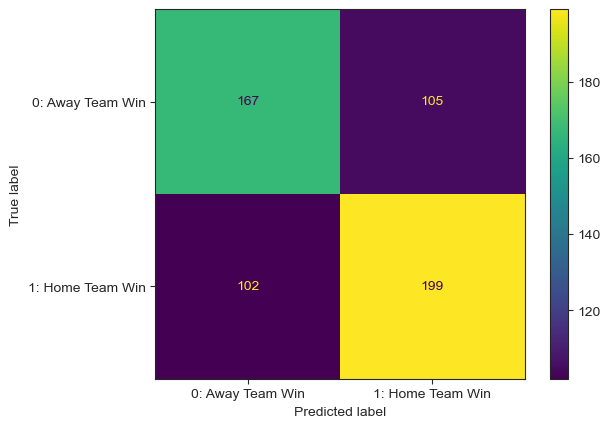

Classification report:
              precision    recall  f1-score   support

           0       0.62      0.61      0.62       272
           1       0.65      0.66      0.66       301

    accuracy                           0.64       573
   macro avg       0.64      0.64      0.64       573
weighted avg       0.64      0.64      0.64       573

Test log loss score: 0.653
Test AUC-ROC score: 0.663


In [225]:
# Calculate the confusion matrix
label_names = ['0: Away Team Win', '1: Home Team Win']
cm = confusion_matrix(yval, log_cv.predict(xval))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(yval, log_cv.predict(xval))
print(f'Classification report:\n{report}')
# Calculate the Log Loss score for the test set
log_loss_score = log_loss(yval, log_cv.predict_proba(xval)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')# Calculate the AUC-ROC score for the test set
# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(yval, log_cv.predict_proba(xval)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')